In [1]:
import numpy as np
import pandas as pd
from matplotlib import patches
import matplotlib.pyplot as plt
from scipy.stats import *
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

In [2]:
dataset='all_beta_center_p001_20190621_500PCs'

# phenotypes to analyze
phe_codes=['INI21001','HC221','HC294','HC326']

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/all_pop/tsvd/'+dataset+'.npz')
scores=pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/'+dataset+'.sscore',
                     index_col='#IID')
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9)
npc=100 #z['D'].shape[0]

# analysis populations
wbr=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                      'ukb24983_white_british.phe').iloc[:,0].tolist())
nbw=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                      'ukb24983_non_british_white.phe').iloc[:,0].tolist())

# phenotype names
with open('/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

# program some special cases
code_to_name['INI21001'] = 'Body mass index'
code_to_name['HC294'] = 'Renal failure'
code_to_name['HC326'] = 'Myocardial infarction'

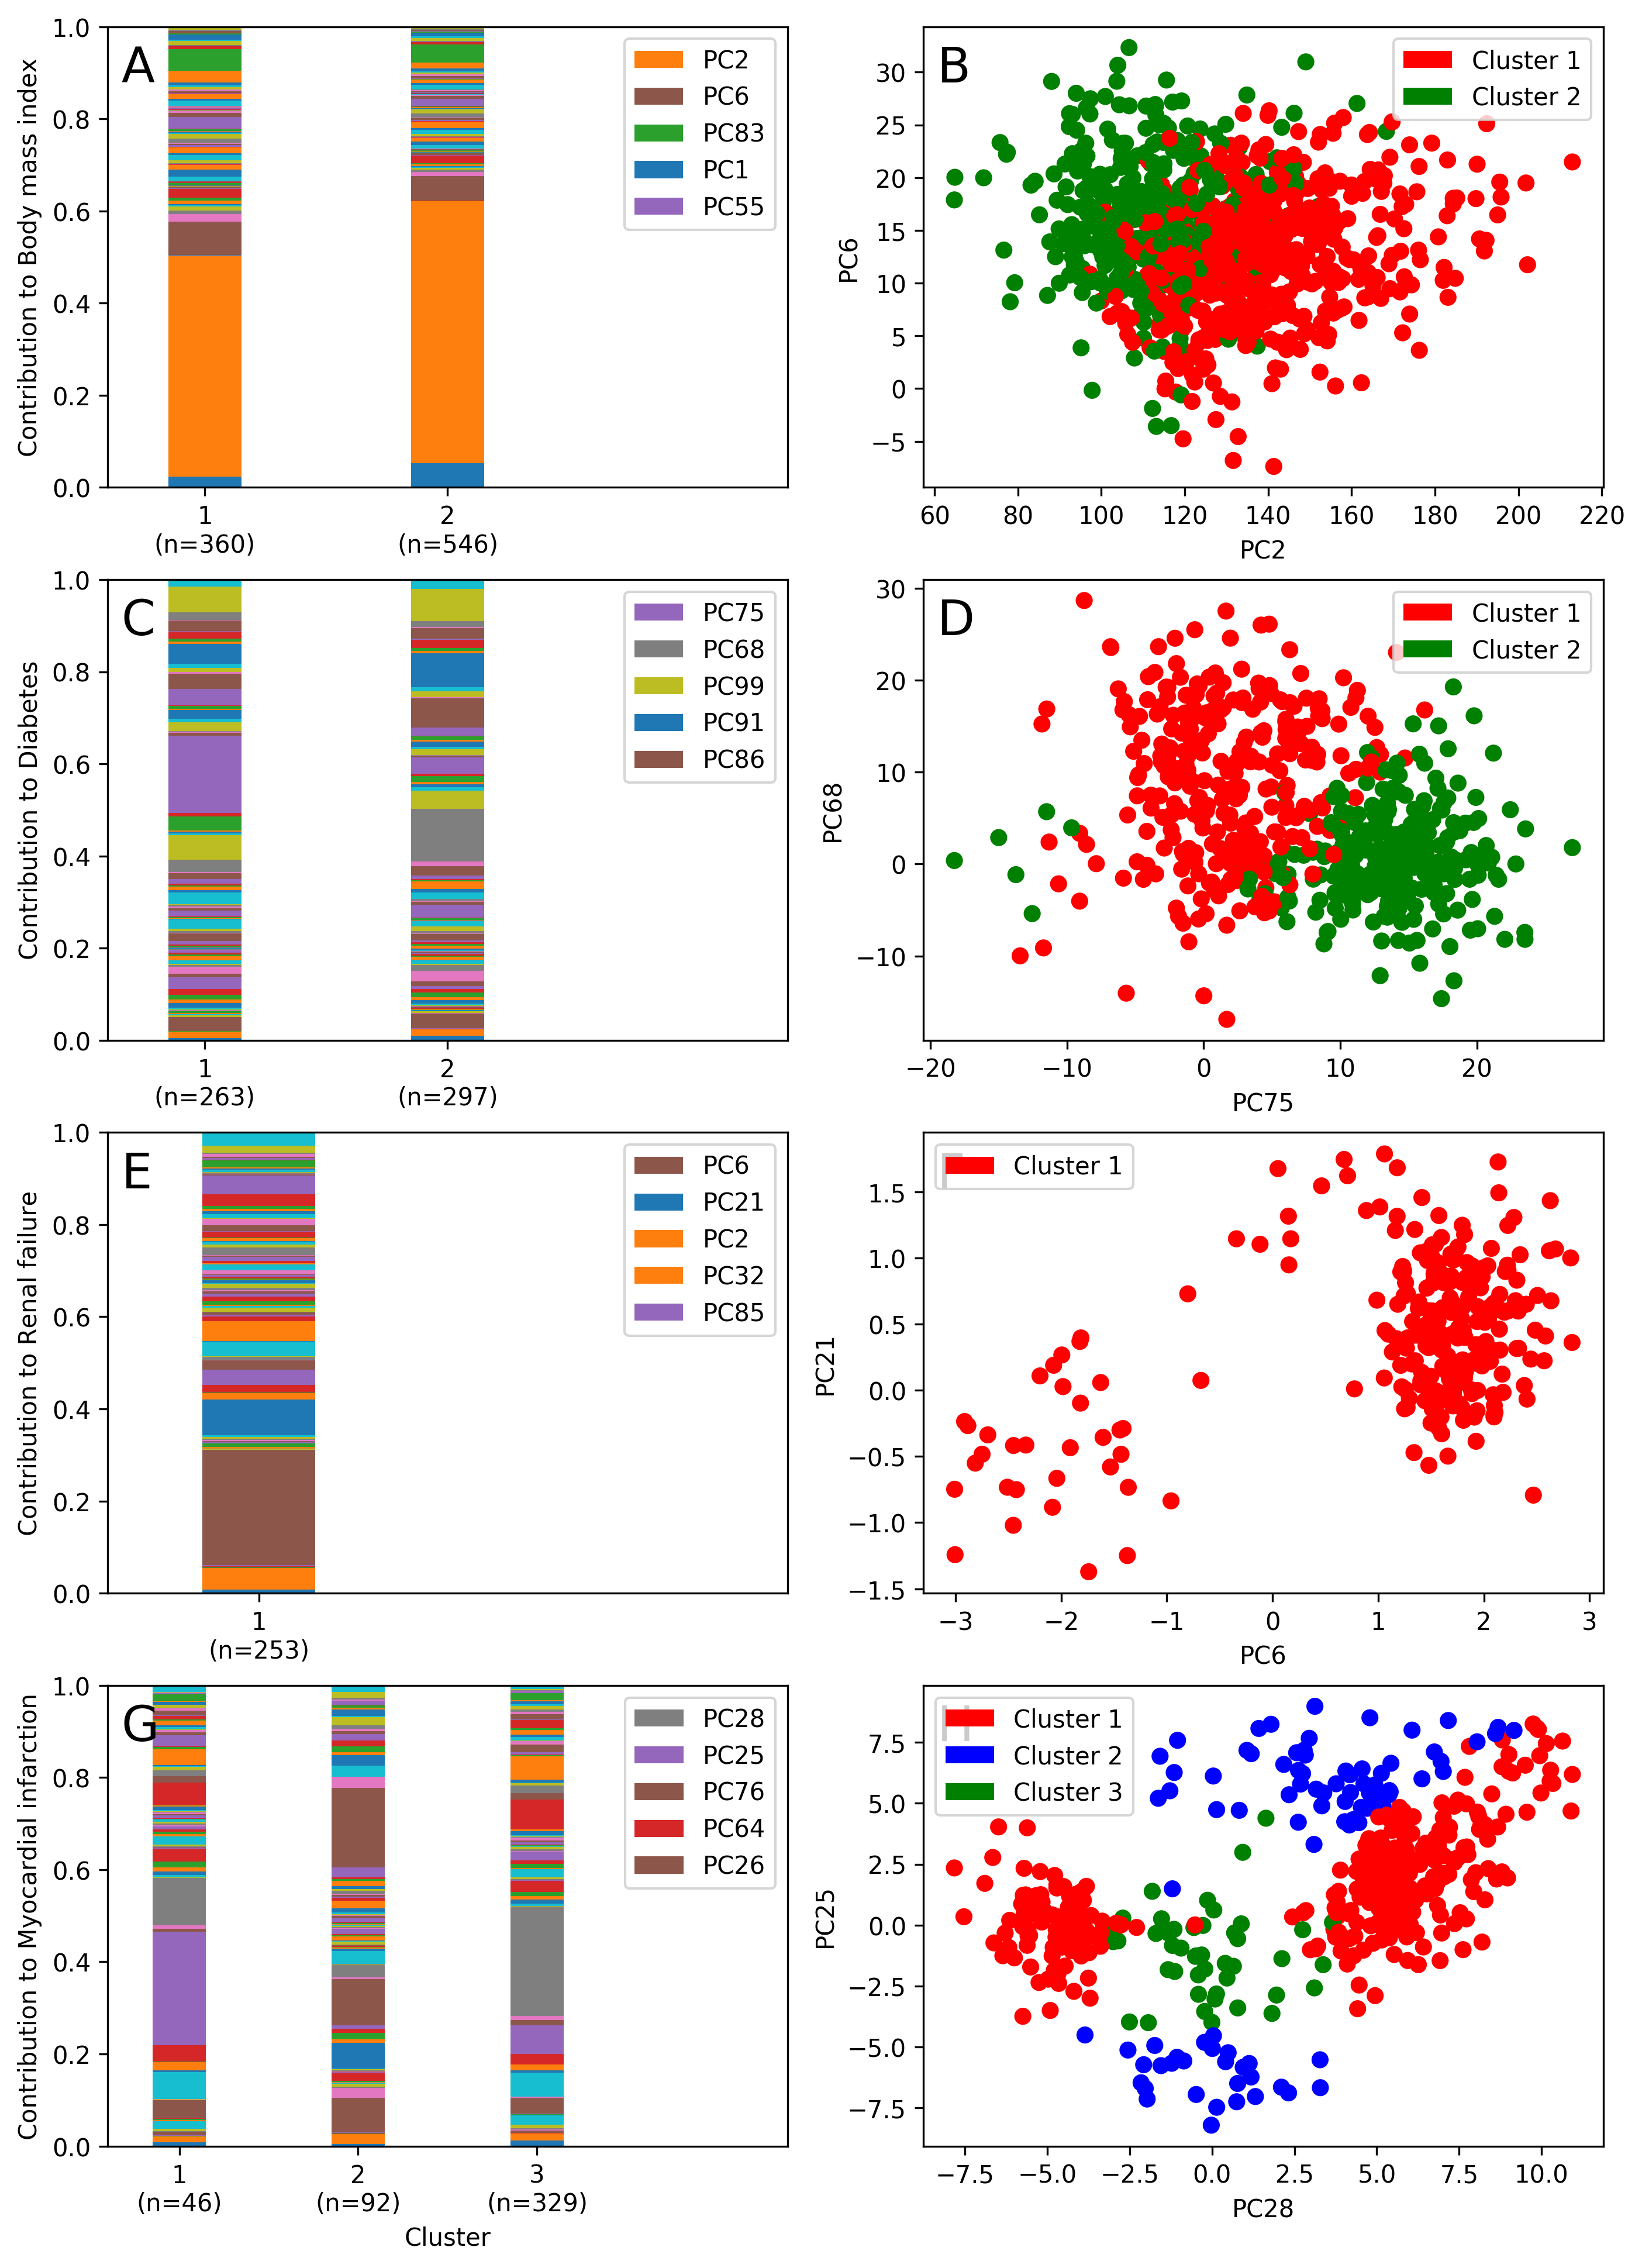

In [34]:
width = 2
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
plt.figure(figsize=(5*width + 1, 4*len(phe_codes)), dpi=300)
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]
for ix,phe_code in enumerate(phe_codes):
    for ix2 in range(width):
        plots[(width*ix)+ix2]=plt.subplot(len(phe_codes), width, width*ix + ix2 + 1)
    # scores and phenotypes
    phe_name=code_to_name[phe_code]
    df=phenos.loc[wbr,[phe_code]+covariate].dropna().merge(scores, left_index=True, right_index=True)
    n=df.shape[0]
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['SCORE']=zscore(scores.loc[df.index.tolist(), score_pcs].dot(weights))
    df.sort_values(by='SCORE',ascending=False,inplace=True)
    
    # filter to cases for clustering binary traits
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        df=df[df[phe_code]==2]
    else:
        is_bin=False
    
    # do painting
    for pc in range(npc):
        df[profl_pcs[pc]]=(df[score_pcs[pc]] * weights[pc] * df['SCORE']).clip_lower(0)
    df[profl_pcs] = normalize(df[profl_pcs], norm='l1')
    
    # identify high risk outliers
    df=df.iloc[:int((0.2 if is_bin else 0.05)*n),:]
    drp_centroid=df[profl_pcs].median()
    df['mahal']=df[profl_pcs].apply(lambda x: euclidean(x, drp_centroid), axis=1)
    m_star=df['mahal'].mean() + 2*df['mahal'].std()
    outliers=df.query('mahal > @m_star').index
    
    # perform clustering
    k=1
    cluster = KMeans(n_clusters=k, n_init=25).fit(df.loc[outliers,profl_pcs])
    pre_frac = 0.85 - 10.0/len(outliers)
    errors = [cluster.inertia_]
    for new_k in [2,3,4,5]:
        new_cluster = KMeans(n_clusters=new_k, n_init=25).fit(df.loc[outliers,profl_pcs])
        errors.append(new_cluster.inertia_)
        if new_k < 6 and (new_cluster.inertia_ / cluster.inertia_ < pre_frac**(new_k - k)): 
            cluster,k = new_cluster,new_k
    
    # (A): paint cluster centers    
    ms = np.flip(cluster.cluster_centers_[0:k],0)
    c_ref = ['red','green','blue','black','magenta','yellow','cyan'][0:k]
    x,p = np.arange(k), []
    top5pcs = np.argsort(np.sum(ms, axis=0))[-5:]
    p=[]
    for i in range(ms.shape[1]):
        zz=plots[(width*ix)].bar(x, ms[:,i], bottom=np.sum(ms[:,0:i], axis=1), width=0.3)
        p.append(zz)
    plots[(width*ix)].set_xlabel('')
    plots[(width*ix)].set_ylabel('Contribution to '+phe_name)
    plots[(width*ix)].set_ylim((0, 1))
    plots[(width*ix)].set_xlim((-0.4,k+0.4))
    plots[(width*ix)].set_xticks(np.arange(k))
    plots[(width*ix)].set_xticklabels([str(x+1)+'\n(n='+str(y)+')' for x,y in 
                              enumerate(reversed(list(pd.Series(cluster.labels_).value_counts())))])
    plots[(width*ix)].legend([p[i] for i in reversed(top5pcs)], 
                               ['PC' + str(i+1) for i in reversed(top5pcs)])
    
    # (B): scatterplot of clusters
    b,a=(str(i+1) for i in top5pcs[-2:])
    for ixx in range(k-1):
        plots[(width*ix)+1].plot([],[],'.',markersize=3,color=c_ref[ixx])
    plots[(width*ix)+1].scatter(df.loc[outliers,'SCORE'+a+'_SUM'].multiply(weights[int(a)-1]),
                                df.loc[outliers,'SCORE'+b+'_SUM'].multiply(weights[int(b)-1]),
                                c=[c_ref[i] for i in cluster.labels_])
    plots[(width*ix)+1].set_xlabel('PC'+a)
    plots[(width*ix)+1].set_ylabel('PC'+b)
    plots[(width*ix)+1].legend([patches.Circle((0.5, 0.5), 1, facecolor=c_ref[-i], linewidth=3) for i in range(k)], 
                               ['Cluster '+str(i+1) for i in range(k)])
    # add figure labels
    for ix2 in range(width):
        plots[(width*ix)+ix2].text(0.02, 0.88, chr((ix*width)+65+ix2), 
                                   fontsize=20, transform=plots[(width*ix)+ix2].transAxes)
    

plots[-2].set_xlabel('Cluster')
plt.show()

In [35]:
df.loc[outliers,'SCORE'].describe()

count    467.000000
mean       0.319275
std        0.600812
min       -1.925748
25%       -0.041999
50%        0.303210
75%        0.673019
max        2.316956
Name: SCORE, dtype: float64

In [33]:
len(outliers)

467